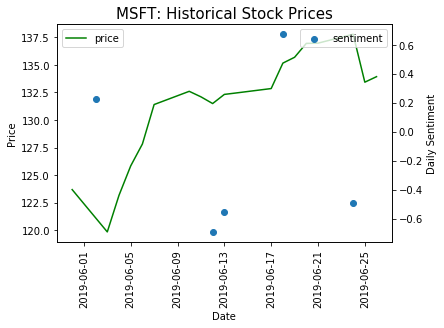

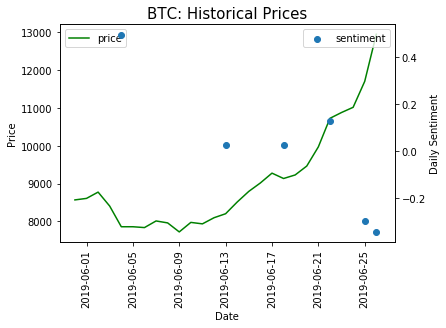

In [23]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.cryptocurrencies import CryptoCurrencies
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import nltk
import json
import statistics
%matplotlib inline

# Description: stockCharts.py pulls historical stock data and includes functions for visualization

ts = TimeSeries(key='EVLE1IR0H06PISXC',output_format='pandas')
cc = CryptoCurrencies(key='EVLE1IR0H06PISXC', output_format='pandas')

# output dataFrame as a csv
def stockPriceToCSV(df,outputFileName):
    df.to_csv(outputFileName)

# output line plot of daily return % with start and end date inputs
def plotDailyReturn(df, start_date, end_date, ticker):
    df["7. date"] = pd.to_datetime(df.index.values)
    mask = (df["7. date"] > start_date) & (df["7. date"] <= end_date)
    df = df.loc[mask]
    
    fig = plt.figure(1)

    # chart formatting
    plt.title(ticker + ': Historical Daily % Returns')
    plt.ylabel("Daily % Return")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    # set y-axis to %
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(5.0))
    

    ax = plt.gca()
    ax2 = ax.twinx()
    plt.plot(df['7. date'],df['6. 1-day % change'])

    plt.show()
    

# output line plot of daily return % with start and end date inputs
def plotPrice(df, start_date, end_date, ticker, df2):
    df["7. date"] = pd.to_datetime(df.index.values)
    mask = (df["7. date"] > start_date) & (df["7. date"] <= end_date)
    df = df.loc[mask]
    
    # chart formatting
    fig = plt.figure(2)
    plt.title(ticker + ': Historical Stock Prices',fontsize=15)
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.xticks(rotation=90)

    ax = plt.gca()
    ax2 = ax.twinx()

    plt.axis('normal')
    ax.plot(df['7. date'], df['4. close'],color='green',label='price')
    ax2.scatter(df2[0], df2[1],label='sentiment')
    ax2.set_ylabel("Daily Sentiment")
    ax.legend(loc='best')
    ax2.legend(loc='best')

    plt.show()

    
# output line plot of daily return % with start and end date inputs
def cryptoPrice(df, start_date, end_date, crypto, df2):
    df["7. date"] = pd.to_datetime(df.index.values)
    mask = (df["7. date"] > start_date) & (df["7. date"] <= end_date)
    df = df.loc[mask]
    
    # chart formatting
    fig = plt.figure(3)
    plt.title(crypto + ': Historical Prices',fontsize=15)
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    
    ax = plt.gca()
    ax2 = ax.twinx()
    plt.axis('normal')
    ax.plot(df['7. date'], df['4b. close (USD)'],color='green',label='price')
    ax2.scatter(df2[0], df2[1],label='sentiment')
    ax2.set_ylabel("Daily Sentiment")
    ax.legend(loc='best')
    ax2.legend(loc='best')
    plt.show()

    
def getCryptoData(crypto):
    # pulls date, open, high, low, volume and closing prices
    data, meta_data = cc.get_digital_currency_daily(symbol='BTC', market='CNY')
    
    return data


# return dataframe from ticker input. adds column that calculates 1-day % change
def getData(ticker):
    # pulls date, open, high, low, volume and closing prices
    df, meta_data = ts.get_daily(symbol=ticker,outputsize='full')
    
    # change/duplicate this for more calcs
    df["6. 1-day % change"] = (df['4. close'] / df['1. open']) - 1 
    
    return df

    plt.show()
    
# parameter should be json file from newsapi output:
def jsonToDF(jsonName):
    with open(jsonName, 'r') as f:
        datastore = json.load(f)

    z = dict()
    for x in range(len(datastore['articles'])):
        date = datastore['articles'][x]['publishedAt'][5:8] + \
            datastore['articles'][x]['publishedAt'][8:10] + "-" + datastore['articles'][x]['publishedAt'][:4]
        z[datastore['articles'][x]['title']] = date

    # sorted(timestamps, key=lambda d: map(int, d.split('-')))

    # calculates score of headlines from csv
    headlines = set()
    sia = SIA()
    results = []
    dictDF = dict()
    for k,v in z.items():
        pol_score = sia.polarity_scores(k)
        pol_score['headline'] = k
        pol_score['date'] = v
        if pol_score['date'] not in dictDF.keys() and pol_score['compound'] != 0.0:
            dictDF[pol_score['date']] = [pol_score['compound']]
        elif pol_score['compound'] != 0.0:
            dictDF[pol_score['date']].append(pol_score['compound'])

    for k, v in dictDF.items():
        dictDF[k] = statistics.mean(v)

    df = pd.DataFrame(dictDF.items())

    df[0] = pd.to_datetime(df[0], format='%m-%d-%Y')
    
    return df

# e.g
# stockPriceToCSV(getData("TSLA"),"tslaoutput.csv")
plotPrice(getData("MSFT"), "05-30-2019", "06-26-2019", "MSFT", jsonToDF("Microsoft.json"))
cryptoPrice(getCryptoData("BTC"), "05-30-2019", "06-26-2019", "BTC", jsonToDF("Bitcoin.json"))
# plotDailyReturn(getData("FB"), "01-31-2019", "03-30-2019", "FB")
